<a href="https://colab.research.google.com/github/plaban1981/Outlier-detection/blob/master/Anomaly_Detection_with_PyOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyOD is a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data. 

In [1]:
!pip install pyod

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 2.1MB 6.9MB/s 
  Created wheel for pyod: filename=pyod-0.7.8-cp36-none-any.whl size=104952 sha256=d9083630888b7e1a54c2b9c13733a85207a34246b7b123fd5e15555ed781c1fe
  Stored in directory: /root/.cache/pip/wheels/7a/72/cc/8d691190b9525ee49125be37ce231bb02ee0c71882dce4a1cd
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=0af13ed31408984a29f514bf2e878c002353d247ae756ad7d64938ab944677fd
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.3-cp36-none-any.whl size=2166457 sha256=a4acf88075fc236bf581b131df575986375cc6eed5e9bbeedebbd71bb57194b5
  Stored in directory: /root/.cache/pip/wheels/15/56/16/6944851600a62d859c89cd11df1adecbe0b6a02f7ad713d4dd
Successfully built pyod combo suod


In [2]:
!pip install --upgrade pyod

Requirement already up-to-date: pyod in /usr/local/lib/python3.6/dist-packages (0.7.8)


##Data
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.

 

##Variable             Description

Item_Identifier          **Unique product ID**

Item_Weight

Weight of product

Item_Fat_Content

Whether the product is low fat or not

Item_Visibility

The % of total display area of all products in a store allocated to the particular product

Item_Type

The category to which the product belongs

Item_MRP

Maximum Retail Price (list price) of the product

Outlet_Identifier

Unique store ID

Outlet_Establishment_Year

The year in which store was established

Outlet_Size

The size of the store in terms of ground area covered

Outlet_Location_Type

The type of city in which the store is located

Outlet_Type

Whether the outlet is just a grocery store or some sort of supermarket

Item_Outlet_Sales

Sales of the product in the particulat store. This is the outcome variable to be predicted.



https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

In [4]:
from google.colab import files
files.upload()

Saving test.csv to test.csv


{'test.csv': b'Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type\r\nFDW58,20.75,Low Fat,0.007564836,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1\r\nFDW14,8.3,reg,0.038427677,Dairy,87.3198,OUT017,2007,,Tier 2,Supermarket Type1\r\nNCN55,14.6,Low Fat,0.099574908,Others,241.7538,OUT010,1998,,Tier 3,Grocery Store\r\nFDQ58,7.315,Low Fat,0.015388393,Snack Foods,155.034,OUT017,2007,,Tier 2,Supermarket Type1\r\nFDY38,,Regular,0.118599314,Dairy,234.23,OUT027,1985,Medium,Tier 3,Supermarket Type3\r\nFDH56,9.8,Regular,0.063817206,Fruits and Vegetables,117.1492,OUT046,1997,Small,Tier 1,Supermarket Type1\r\nFDL48,19.35,Regular,0.082601537,Baking Goods,50.1034,OUT018,2009,Medium,Tier 3,Supermarket Type2\r\nFDC48,,Low Fat,0.015782495,Baking Goods,81.0592,OUT027,1985,Medium,Tier 3,Supermarket Type3\r\nFDN33,6.305,Regular,0.123365446,Snack Foods,95.7436,OUT045,2002,,T

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# Import models
from scipy import stats
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [0]:
# reading the big mart sales training data
df = pd.read_csv("train.csv")

In [7]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


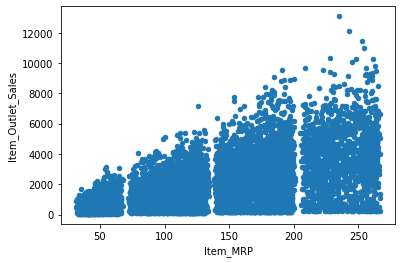

In [8]:
df.plot.scatter('Item_MRP','Item_Outlet_Sales')

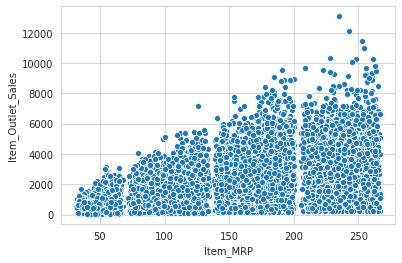

In [11]:
import seaborn as sns
sns.set_style('whitegrid')
sns.scatterplot(x='Item_MRP',y='Item_Outlet_Sales',data=df,legend='full')

The range of Item Outlet Sales is from 0 to 12000 and Item MRP is from 0 to 250. We will scale down both these features to a range between 0 and 1. This is required to create a explainable visualization (it will become way too stretched otherwise)

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP','Item_Outlet_Sales']])
df[['Item_MRP','Item_Outlet_Sales']].head()

,Item_MRP,Item_Outlet_Sales
0,0.927507,0.283587
1,0.072068,0.031419
2,0.468288,0.158115
3,0.640093,0.053555
4,0.095805,0.073651


Store these values in the NumPy array for using in our models later:

In [0]:
X1 = df['Item_MRP'].values.reshape(-1,1)
X2 = df['Item_Outlet_Sales'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

In [14]:
X

array([[0.92750715, 0.28358666],
       [0.0720684 , 0.03141895],
       [0.46828841, 0.15811486],
       ...,
       [0.22849221, 0.08885035],
       [0.30493925, 0.13883505],
       [0.18750976, 0.05610527]])

In [17]:
X.shape

(8523, 2)

In [0]:
x = df[['Item_MRP','Item_Outlet_Sales']].values

In [16]:
x

array([[0.92750715, 0.28358666],
       [0.0720684 , 0.03141895],
       [0.46828841, 0.15811486],
       ...,
       [0.22849221, 0.08885035],
       [0.30493925, 0.13883505],
       [0.18750976, 0.05610527]])

In [18]:
x.shape

(8523, 2)

## Angle-Based Outlier Detection (ABOD)


It considers the relationship between each point and its neighbor(s). It does not consider the relationships among these neighbors. The variance of its weighted cosine scores to all neighbors could be viewed as the outlying score
ABOD performs well on multi-dimensional data
PyOD provides two different versions of ABOD:
Fast ABOD: Uses k-nearest neighbors to approximate
Original ABOD: Considers all training points with high-time complexity

## k-Nearest Neighbors Detector


For any data point, the distance to its kth nearest neighbor could be viewed as the outlying score
PyOD supports three kNN detectors:
Largest: Uses the distance of the kth neighbor as the outlier score
Mean: Uses the average of all k neighbors as the outlier score
Median: Uses the median of the distance to k neighbors as the outlier score


## Isolation Forest

It uses the scikit-learn library internally. In this method, data partitioning is done using a set of trees. Isolation Forest provides an anomaly score looking at how isolated the point is in the structure. The anomaly score is then used to identify outliers from normal observations
Isolation Forest performs well on multi-dimensional data

## Histogram-based Outlier Detection

It is an efficient unsupervised method which assumes the feature independence and calculates the outlier score by building histograms
It is much faster than multivariate approaches, but at the cost of less precision

## Local Correlation Integral (LOCI)

LOCI is very effective for detecting outliers and groups of outliers. It provides a LOCI plot for each point which summarizes a lot of the information about the data in the area around the point, determining clusters, micro-clusters, their diameters, and their inter-cluster distances
None of the existing outlier-detection methods can match this feature because they output only a single number for each point
 
## Feature Bagging

A feature bagging detector fits a number of base detectors on various sub-samples of the dataset. It uses averaging or other combination methods to improve the prediction accuracy
By default, Local Outlier Factor (LOF) is used as the base estimator. However, any estimator could be used as the base estimator, such as kNN and ABOD
Feature bagging first constructs n sub-samples by randomly selecting a subset of features. This brings out the diversity of base estimators. Finally, the prediction score is generated by averaging or taking the maximum of all base detectors.

## Clustering Based Local Outlier Factor

It classifies the data into small clusters and large clusters. The anomaly score is then calculated based on the size of the cluster the point belongs to, as well as the distance to the nearest large cluster
 

## Extra Utilities provided by PyOD

A function generate_data can be used to generate random data with outliers. Inliers data is generated by a multivariate Gaussian distribution and outliers are generated by a uniform distribution.
We can provide our own values of outliers fraction and the total number of samples that we want in our dataset. We will use this utility function to create data in the implementation part.
 

#####  Detect 5% observations that are not similar to the rest of the data.

In [0]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

#### Fit the data to each model one by one and see how differently each model predicts the outliers.

OUTLIERS :  447 INLIERS :  8076 Angle-based Outlier Detector (ABOD)


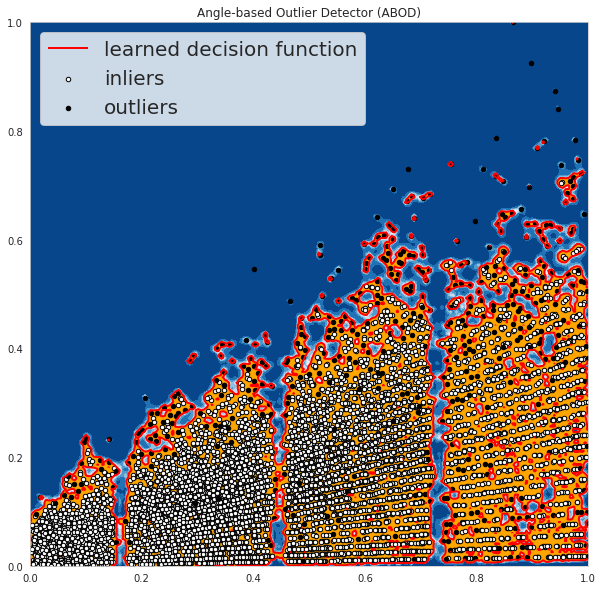

OUTLIERS :  427 INLIERS :  8096 Cluster-based Local Outlier Factor (CBLOF)


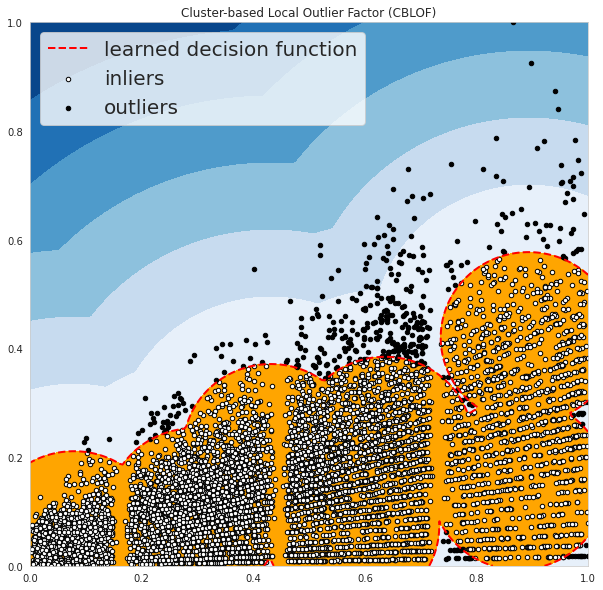

OUTLIERS :  369 INLIERS :  8154 Feature Bagging


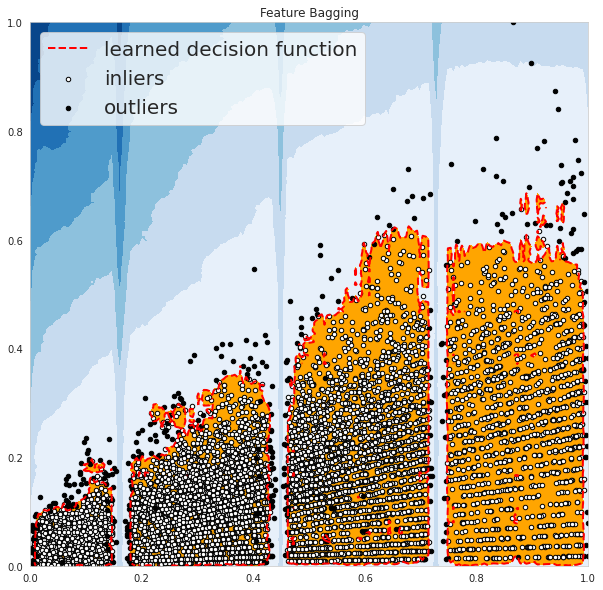

OUTLIERS :  501 INLIERS :  8022 Histogram-base Outlier Detection (HBOS)


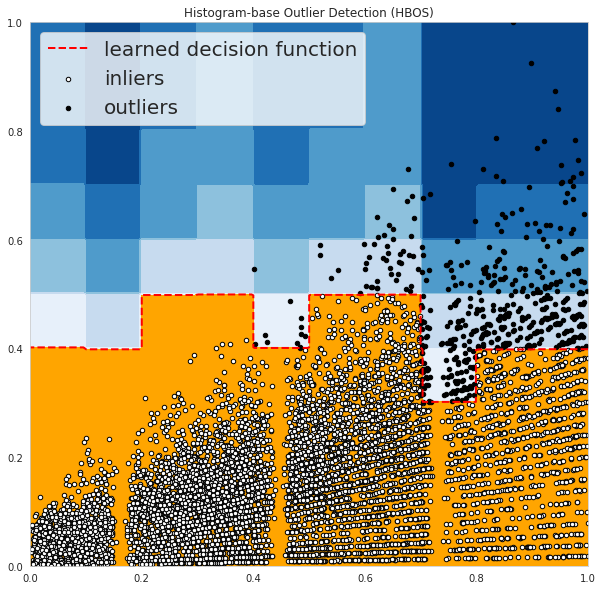

OUTLIERS :  427 INLIERS :  8096 Isolation Forest


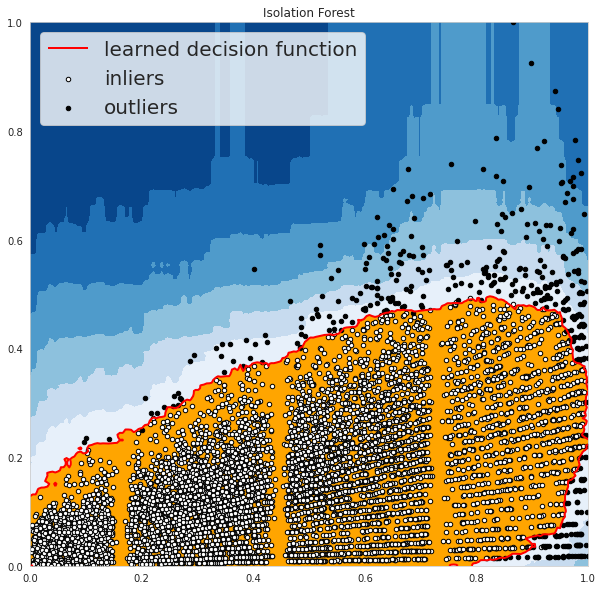

OUTLIERS :  311 INLIERS :  8212 K Nearest Neighbors (KNN)


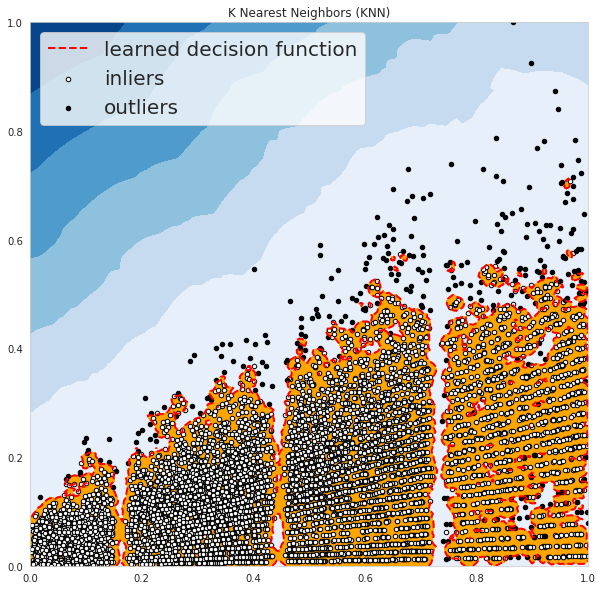

OUTLIERS :  176 INLIERS :  8347 Average KNN


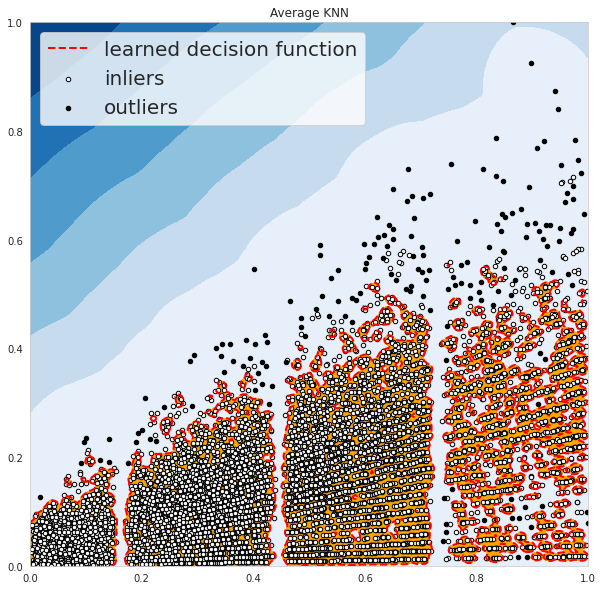

In [25]:
#### 
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))
####
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    #IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    #IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)

    IX1 = dfx['Item_MRP'][dfx['outlier'] == 0].values
    IX2 = dfx['Item_Outlet_Sales'][dfx['outlier'] == 0].values
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    #OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    #OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)

    OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values
    OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()